# PneumoniaMNIST – Classificazione immagini (CNN)
**Pipeline:** dataset → preprocessing → training → valutazione → metriche (ROC/AUC)
Dataset: [MedMNIST](https://medmnist.com/) – *PneumoniaMNIST*.


In [1]:
# Install (if needed) – esegui una volta per ambiente
# %pip install medmnist torch torchvision torchaudio tqdm matplotlib scikit-learn


In [2]:
import os, sys, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import medmnist
from medmnist import PneumoniaMNIST
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import random

SEED = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cpu


## 1) Dataset & Preprocessing

In [3]:
import os, pathlib

# Imposta directory dati a livello progetto e creala se non esiste
data_root = str(pathlib.Path.cwd().parent / "data")
os.makedirs(data_root, exist_ok=True)
download = True

transform = transforms.Compose([
    transforms.ToTensor(),  # converte in [0,1]
    transforms.Normalize(mean=[.5], std=[.5]),  # scala in [-1,1]
])

train_ds = PneumoniaMNIST(split='train', root=data_root, download=download, transform=transform)
val_ds   = PneumoniaMNIST(split='val',   root=data_root, download=download, transform=transform)
test_ds  = PneumoniaMNIST(split='test',  root=data_root, download=download, transform=transform)

batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2)

n_classes = len(np.unique(train_ds.labels))
print('Classi:', n_classes)


Classi: 2


## 2) Modello (CNN)

In [4]:
class SmallCNN(nn.Module):
    def __init__(self, n_classes=2):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(32*7*7, 64)  # immagini 28x28
        self.fc2 = nn.Linear(64, n_classes)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

model = SmallCNN(n_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## 3) Training + Early Stopping (val AUC)

In [5]:
def eval_auc(loader):
    model.eval()
    y_true, y_prob, y_pred = [], [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.squeeze().long().to(device)
            logits = model(x)
            prob = F.softmax(logits, dim=1)[:,1].detach().cpu().numpy()
            pred = logits.argmax(1).detach().cpu().numpy()
            y_true.extend(y.cpu().numpy()); y_prob.extend(prob); y_pred.extend(pred)
    auc = roc_auc_score(y_true, y_prob)
    acc = accuracy_score(y_true, y_pred)
    return auc, acc

best_auc, patience, patience_ctr = -1, 5, 0
EPOCHS = 15
for epoch in range(1, EPOCHS+1):
    model.train()
    losses = []
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}"):
        x, y = x.to(device), y.squeeze().long().to(device)
        optimizer.zero_grad()
        loss = criterion(model(x), y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    val_auc, val_acc = eval_auc(val_loader)
    print(f"Epoch {epoch}: train_loss={np.mean(losses):.4f} | val_auc={val_auc:.4f} | val_acc={val_acc:.4f}")
    if val_auc > best_auc:
        best_auc = val_auc; patience_ctr = 0
        torch.save(model.state_dict(), 'best_cnn.pt')
    else:
        patience_ctr += 1
        if patience_ctr >= patience:
            print("Early stopping.")
            break

Epoch 1/15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:14<00:00,  2.57it/s]


Epoch 1: train_loss=0.4177 | val_auc=0.9711 | val_acc=0.9351


Epoch 2/15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:14<00:00,  2.58it/s]


Epoch 2: train_loss=0.1801 | val_auc=0.9820 | val_acc=0.9504


Epoch 3/15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:14<00:00,  2.56it/s]


Epoch 3: train_loss=0.1498 | val_auc=0.9853 | val_acc=0.9485


Epoch 4/15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:16<00:00,  2.30it/s]


Epoch 4: train_loss=0.1394 | val_auc=0.9870 | val_acc=0.9561


Epoch 5/15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:15<00:00,  2.43it/s]


Epoch 5: train_loss=0.1265 | val_auc=0.9891 | val_acc=0.9523


Epoch 6/15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:14<00:00,  2.63it/s]


Epoch 6: train_loss=0.1193 | val_auc=0.9902 | val_acc=0.9561


Epoch 7/15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:15<00:00,  2.40it/s]


Epoch 7: train_loss=0.1073 | val_auc=0.9900 | val_acc=0.9618


Epoch 8/15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:14<00:00,  2.55it/s]


Epoch 8: train_loss=0.1074 | val_auc=0.9910 | val_acc=0.9485


Epoch 9/15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:14<00:00,  2.55it/s]


Epoch 9: train_loss=0.0921 | val_auc=0.9915 | val_acc=0.9561


Epoch 10/15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:14<00:00,  2.49it/s]


Epoch 10: train_loss=0.0936 | val_auc=0.9929 | val_acc=0.9580


Epoch 11/15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:14<00:00,  2.54it/s]


Epoch 11: train_loss=0.0941 | val_auc=0.9931 | val_acc=0.9542


Epoch 12/15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:14<00:00,  2.48it/s]


Epoch 12: train_loss=0.0825 | val_auc=0.9930 | val_acc=0.9599


Epoch 13/15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:14<00:00,  2.53it/s]


Epoch 13: train_loss=0.0753 | val_auc=0.9941 | val_acc=0.9676


Epoch 14/15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:14<00:00,  2.53it/s]


Epoch 14: train_loss=0.0729 | val_auc=0.9942 | val_acc=0.9676


Epoch 15/15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:14<00:00,  2.54it/s]


Epoch 15: train_loss=0.0699 | val_auc=0.9940 | val_acc=0.9599


## 4) Valutazione su test set (ROC, AUC, Confusion Matrix)

AUC (test): 0.9337, ACC: 0.8526


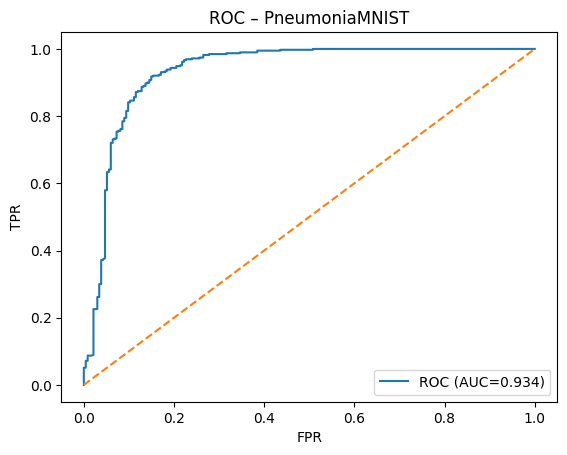

Confusion Matrix:
 [[146  88]
 [  4 386]]


In [6]:
model.load_state_dict(torch.load('best_cnn.pt', map_location=device))
model.eval()
y_true, y_prob, y_pred = [], [], []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.squeeze().long().to(device)
        logits = model(x)
        prob = F.softmax(logits, dim=1)[:,1].detach().cpu().numpy()
        pred = logits.argmax(1).detach().cpu().numpy()
        y_true.extend(y.cpu().numpy()); y_prob.extend(prob); y_pred.extend(pred)

test_auc = roc_auc_score(y_true, y_prob)
fpr, tpr, thr = roc_curve(y_true, y_prob)
acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print(f"AUC (test): {test_auc:.4f}, ACC: {acc:.4f}")
plt.figure()
plt.plot(fpr, tpr, label=f'ROC (AUC={test_auc:.3f})')
plt.plot([0,1],[0,1],'--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC – PneumoniaMNIST')
plt.legend(); plt.show()

print("Confusion Matrix:\n", cm)